# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations

sys.path.append("../src/")

import xgi
from reducibility_hg import *

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir  = f"{results_dir}synthetic/"

In [3]:
def plot_3panels(info_losses, complexities, orders, labels, legend_title=None):
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.1), constrained_layout=True, sharey=True)

    n = len(info_losses)
    
    for i in range(n):
        ax1.plot(orders[i], info_losses[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax1.set_title("Information Loss (KL)")
    ax1.set_xlabel("Max Order")
    ax1.set_ylabel("Bits")
    
    for i in range(n):
        ax2.plot(orders[i], complexities[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax2.set_title("Model Complexity ($\delta S$)")
    ax2.set_xlabel("Max Order")
    
    for i in range(n):
        message_length = complexities[i] + info_losses[i]
        ax3.plot(orders[i], message_length, "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax3.legend(title=legend_title, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left")

    ax3.set_title("Message Length")
    ax3.set_xlabel("Max Order")

    sb.despine()

    #fig.suptitle(f"Complete hypergraph N={N}")

    #fig_name = f"message_length_complete_hypergraph_N{N}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

    #plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
    
    return fig, (ax1, ax2, ax3)

# Complete Hypergraph up to order 4

In [4]:
N = 30
rescale = False

H0 = xgi.complete_hypergraph(N=N, max_order=4)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [5]:
tau_D = find_charact_tau(H0, orders, weights, rescale_per_node=False)
tau_D

0.09666666666666658

In [6]:
def optimization_rescaled(H, tau, rescaling_factors, rescale_per_node=False, sparse=False):

    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node, sparse=sparse
    )

    rho_all = density(L_multi, tau, sparse=sparse)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H, orders[0 : l + 1], weights[0 : l + 1], rescale_per_node=rescale_per_node, sparse=sparse
        )
        rho_l = density(L_l, tau*rescaling_factors[l], sparse=sparse)
        d = KL(rho_all, rho_l, sparse=sparse)
        z = penalization(L_l, tau*rescaling_factors[l], sparse=sparse)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ

In [14]:
rho_D = density(xgi.multiorder_laplacian(H0, orders, weights), tau_D)
rho_1 = density(xgi.multiorder_laplacian(H0, orders[:1], weights[:1]), tau_D*10)

sum(sum(rho_D-rho_1))

0.0

In [12]:
rf_1 = 1
rf_2 = rf_1 + 2
rf_3 = rf_2 + 3
rf_4 = rf_3 + 4
inverse_rescaling_factors = np.array([1/rf_1, 1/rf_2, 1/rf_3, 1/rf_4]) * rf_4
Ds_H, lZs_H = optimization_rescaled(H0, tau_D, inverse_rescaling_factors, rescale_per_node=rescale)
Ds_H, lZs_H

(array([0.00000000e+00, 7.07767178e-16, 7.07767178e-16, 0.00000000e+00]),
 array([0.03000494, 0.03000494, 0.03000494, 0.03000494]))

(<Figure size 700x210 with 3 Axes>,
 (<AxesSubplot:title={'center':'Information Loss (KL)'}, xlabel='Max Order', ylabel='Bits'>,
  <AxesSubplot:title={'center':'Model Complexity ($\\delta S$)'}, xlabel='Max Order'>,
  <AxesSubplot:title={'center':'Message Length'}, xlabel='Max Order'>))

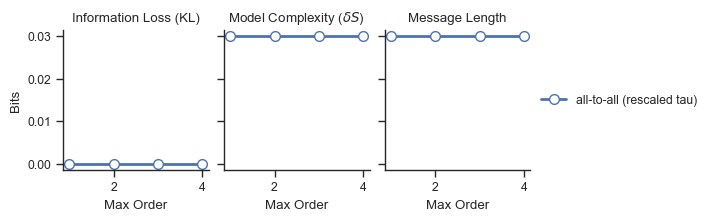

In [21]:
plot_3panels([Ds_H], [lZs_H], [orders], ["all-to-all (rescaled tau)"], legend_title=None)

In [26]:
rescale = False
max_order = 4

rf_1 = 1
rf_2 = rf_1 + 2
rf_3 = rf_2 + 3
rf_4 = rf_3 + 4
inverse_rescaling_factors = np.array([1/rf_1, 1/rf_2, 1/rf_3, 1/rf_4]) * rf_4

Ds_H = np.zeros((3,4))
lZs_H = np.zeros((3,4))

for i, N in enumerate(range(10,31,10)):

    H0 = xgi.complete_hypergraph(N=N, max_order=max_order)

    orders = np.array(xgi.unique_edge_sizes(H0)) - 1
    weights = np.ones(len(orders))

    tau_D = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)
 
    Ds_H[i], lZs_H[i] = optimization_rescaled(H0, tau_D, inverse_rescaling_factors, rescale_per_node=rescale)